<a href="https://colab.research.google.com/github/ShubhamW248/AutoEncoders/blob/main/Autoencoders_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Denoising using Autoencoders**

One task which can be accomplished using autoencoders is the removal of noise from images. In this case, the autoencoder has to be trained on feature-label pairs where the feature is an image containing noise and the label is an image without noise.


### Steps:
1. Load the MNIST dataset.
2. Add salt and pepper noise to the images.
3. Build the autoencoder model using Keras.
4. Train the model to reconstruct clean images from noisy images.
5. Visualize the results.



In [ ]:
# Step 1: Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam


In [ ]:
def add_salt_and_pepper_noise(images, noise_ratio=0.1):
    noisy_images = images.copy()  # Copy images to avoid modifying the original array
    num_salt = int(np.ceil(noise_ratio * images[0].size * 0.5))  # Number of salt pixels
    num_pepper = int(np.ceil(noise_ratio * images[0].size * 0.5))  # Number of pepper pixels

    for img in noisy_images:
        # Add salt (white pixels)
        salt_coords = [
            np.random.randint(0, i, num_salt) for i in img.shape
        ]
        img[salt_coords[0], salt_coords[1], :] = 1

        # Add pepper (black pixels)
        pepper_coords = [
            np.random.randint(0, i, num_pepper) for i in img.shape
        ]
        img[pepper_coords[0], pepper_coords[1], :] = 0

    return noisy_images


### **Load and preprocess the MNIST dataset**

We will load the MNIST dataset, normalize the images, and add salt-and-pepper noise to the training and testing images.


In [ ]:
# Load the MNIST dataset (full dataset)
(x_train, _), (x_test, _) = mnist.load_data()

# Specify the number of samples to load (e.g., 10,000 from training and 2,000 from testing)
n_train_samples = 10000
n_test_samples = 2000

# Reduce the size of the dataset
x_train = x_train[:n_train_samples]
x_test = x_test[:n_test_samples]

# Normalize the images (0-1 range)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the images to add the channel dimension
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Verify the shapes


In [ ]:
x_train_noisy = add_salt_and_pepper_noise(x_train)
x_test_noisy = add_salt_and_pepper_noise(x_test)


### Step 3: Visualize the noisy vs. original images

Let's visualize a few noisy and original images side by side to understand the effect of the salt-and-pepper noise.





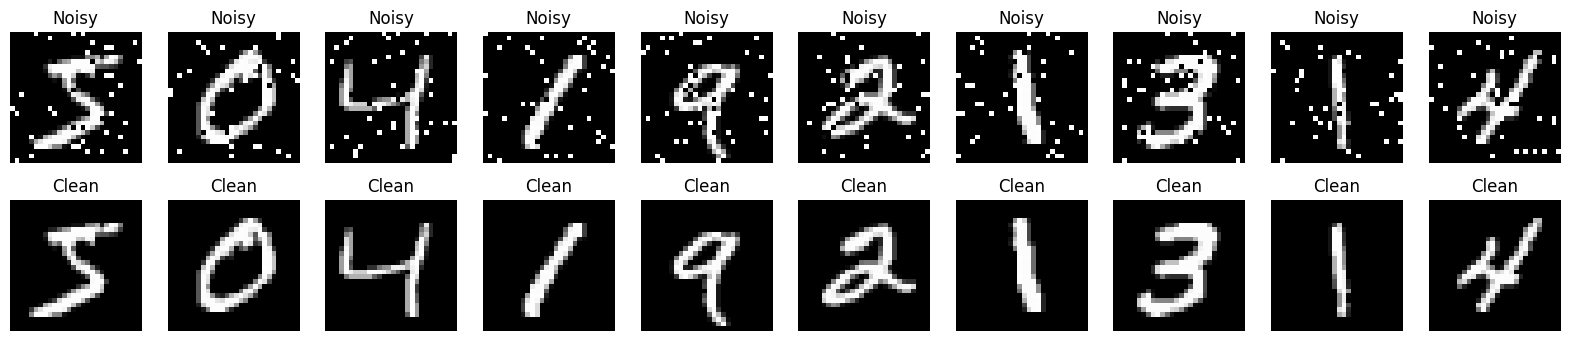

In [ ]:
# Function to display images
def plot_images(noisy, clean, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Noisy images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy[i].reshape(28, 28), cmap="gray")
        plt.title("Noisy")
        plt.axis("off")

        # Clean images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(clean[i].reshape(28, 28), cmap="gray")
        plt.title("Clean")
        plt.axis("off")

# Plot noisy vs clean
plot_images(x_train_noisy, x_train)


### Step 4: Build the autoencoder model

We'll now build a simple autoencoder model using Keras. The model will have an encoder that compresses the noisy image into a latent space, and a decoder that reconstructs the clean image from this latent space.


In [ ]:
# Encoder
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
encoded = Dense(128, activation='relu')(x)

# Decoder
decoded = Dense(28*28, activation='sigmoid')(encoded)
decoded = Reshape((28, 28, 1))(decoded)

# Autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

# Print model summary
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 201,616 (787.56 KB)

 Trainable params: 201,616 (787.56 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the autoencoder
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4279 - val_loss: 0.2155
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2014 - val_loss: 0.1697
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1619 - val_loss: 0.1466
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1410 - val_loss: 0.1321
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1271 - val_loss: 0.1232
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1184 - val_loss: 0.1162
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1120 - val_loss: 0.1118
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1077 - val_loss: 0.1077
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1035 - val_loss: 0.1049
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1001 - val_loss: 0.1020


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


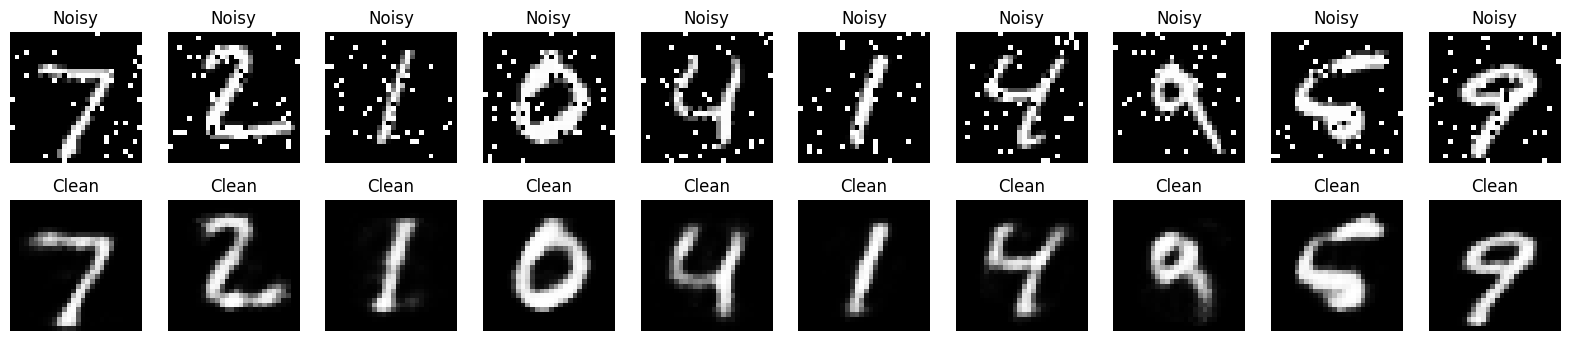

In [ ]:
# Predict denoised images
denoised_images = autoencoder.predict(x_test_noisy)

# Display the noisy and denoised images
plot_images(x_test_noisy, denoised_images)
